Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_path = 'drive/My Drive/Colab Notebooks/Melanoma Assignment'

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
data_dir_train = pathlib.Path(root_path+"/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path(root_path+"/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data


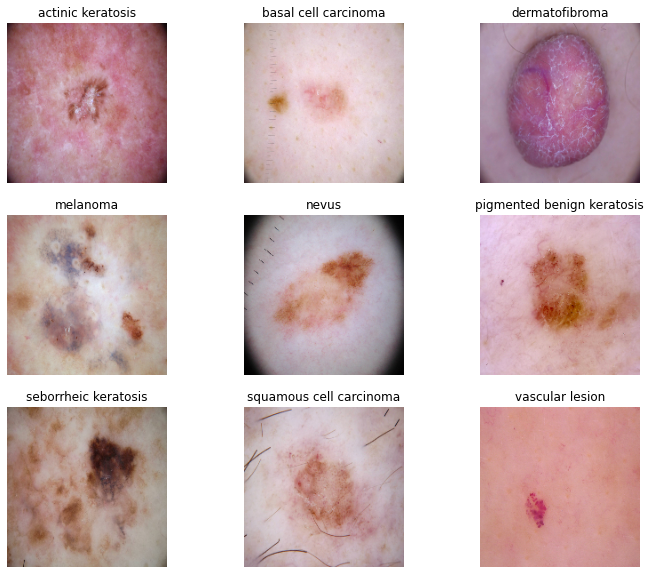

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
for i in range(len(class_names)):
  filtered_ds = train_ds.filter(lambda x,l:tf.math.equal(l[0], i))
  for image, label in filtered_ds.take(1):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[0].numpy().astype('uint8'))
    plt.title(class_names[label.numpy()[0]])
    plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [39]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
####  Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [40]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [43]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 70s 648ms/step - loss: 1.8914 - accuracy: 0.3136 - val_loss: 1.6378 - val_accuracy: 0.4273
Epoch 2/20
56/56 [==============================] - 2s 43ms/step - loss: 1.5378 - accuracy: 0.4682 - val_loss: 1.4912 - val_accuracy: 0.4966
Epoch 3/20
56/56 [==============================] - 2s 42ms/step - loss: 1.4019 - accuracy: 0.5223 - val_loss: 1.3831 - val_accuracy: 0.5481
Epoch 4/20
56/56 [==============================] - 2s 42ms/step - loss: 1.2731 - accuracy: 0.5569 - val_loss: 1.5196 - val_accuracy: 0.4720
Epoch 5/20
56/56 [==============================] - 2s 42ms/step - loss: 1.2331 - accuracy: 0.5670 - val_loss: 1.4545 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 2s 42ms/step - loss: 1.1512 - accuracy: 0.5954 - val_loss: 1.4826 - val_accuracy: 0.4787
Epoch 7/20
56/56 [==============================] - 2s 43ms/step - loss: 1.0812 - accuracy: 0.6250 - val_loss: 1.4368 - val_accuracy: 0.5526
Epoch 8/20


### Visualizing training results

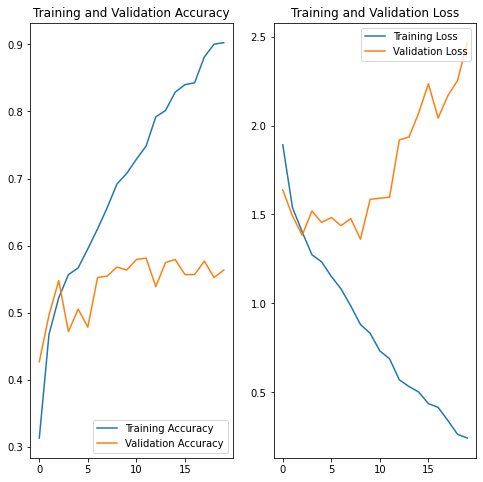

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###Findings:
1] We can clearly observe a drastic difference between Traning and Validation Accuracy, which indicates that the model has overfitted<br>
2] Also we can observe that the validation accuracy the model has achieved is below 55 % <br>
Overall we need to apply techniques like <b>Data Augmentation and Dropout</b> to handle the overfitting issue of the model

### Data Augmentation

In [45]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

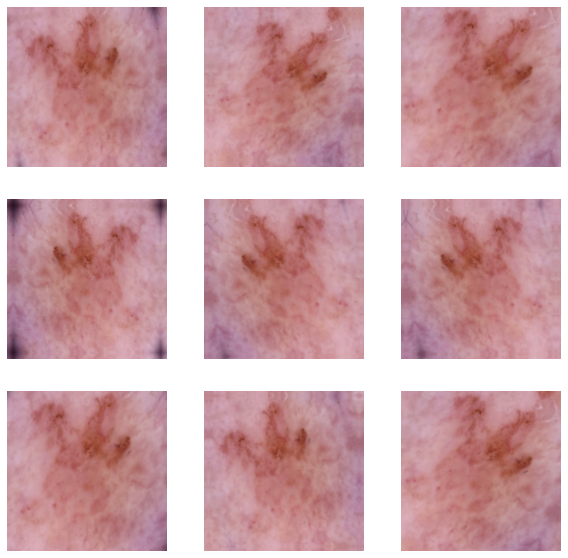

In [46]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model


In [47]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [48]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [49]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 54ms/step - loss: 1.9529 - accuracy: 0.2578 - val_loss: 1.7798 - val_accuracy: 0.3289
Epoch 2/20
56/56 [==============================] - 3s 59ms/step - loss: 1.6641 - accuracy: 0.4107 - val_loss: 1.6178 - val_accuracy: 0.4430
Epoch 3/20
56/56 [==============================] - 3s 59ms/step - loss: 1.6352 - accuracy: 0.4096 - val_loss: 1.5841 - val_accuracy: 0.4139
Epoch 4/20
56/56 [==============================] - 3s 55ms/step - loss: 1.5623 - accuracy: 0.4308 - val_loss: 1.5626 - val_accuracy: 0.4228
Epoch 5/20
56/56 [==============================] - 3s 60ms/step - loss: 1.4418 - accuracy: 0.4749 - val_loss: 1.4537 - val_accuracy: 0.5101
Epoch 6/20
56/56 [==============================] - 3s 56ms/step - loss: 1.3688 - accuracy: 0.5179 - val_loss: 1.4102 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 3s 49ms/step - loss: 1.3423 - accuracy: 0.5262 - val_loss: 1.3921 - val_accuracy: 0.4989
Epoch 8/20
56

### Visualizing the results

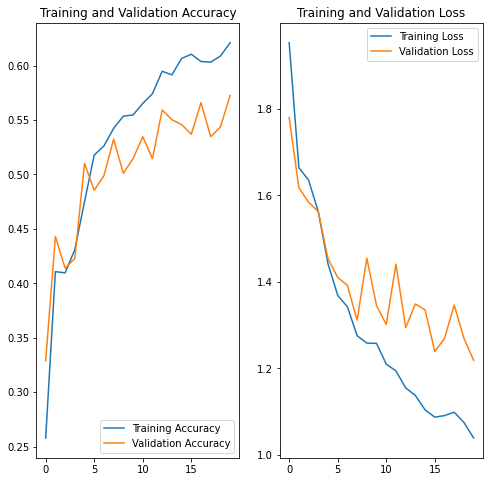

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings:
As we can see that now the Training and Validation accuracy are almost in the same level and the highest accuracy achieved is around 60% , this shows the impact of how performing Data Augmentation can improve the model performance<br>
But we can still try to increase the accuracy of the model

## Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [51]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict_original = dict(zip(path_list, lesion_list))
df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
df

,Path,Label
0,drive/My Drive/Colab Notebooks/Melanoma Assign...,basal cell carcinoma
1,drive/My Drive/Colab Notebooks/Melanoma Assign...,basal cell carcinoma
2,drive/My Drive/Colab Notebooks/Melanoma Assign...,basal cell carcinoma
3,drive/My Drive/Colab Notebooks/Melanoma Assign...,basal cell carcinoma
4,drive/My Drive/Colab Notebooks/Melanoma Assign...,basal cell carcinoma
...,...,...
2234,drive/My Drive/Colab Notebooks/Melanoma Assign...,pigmented benign keratosis
2235,drive/My Drive/Colab Notebooks/Melanoma Assign...,pigmented benign keratosis
2236,drive/My Drive/Colab Notebooks/Melanoma Assign...,pigmented benign keratosis
2237,drive/My Drive/Colab Notebooks/Melanoma Assign...,pigmented benign keratosis


Class=1, n=376 (16.793%)
Class=0, n=114 (5.092%)
Class=4, n=357 (15.945%)
Class=3, n=438 (19.562%)
Class=2, n=95 (4.243%)
Class=8, n=139 (6.208%)
Class=7, n=181 (8.084%)
Class=6, n=77 (3.439%)
Class=5, n=462 (20.634%)


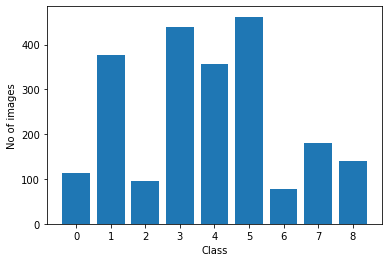

In [52]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter

X, y = df['Path'], df['Label']
y = LabelEncoder().fit_transform(y)
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.xticks([i for i in range(9)])
plt.xlabel("Class")
plt.ylabel("No of images")
plt.show()

## Write your findings here: 
#### - Which class has the least number of samples?
<b>Ans]</b> From the above bar chart we can see that the class with label 6 has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
<b>Ans]</b> We can observe that of all the class, class with label 5 has the most number of samples

##Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [53]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [54]:
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to drive/My Drive/Colab Notebooks/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA333146E10>: 100%|██████████| 500/500 [00:26<00:00, 19.11 Samples/s]


Initialised with 376 image(s) found.
Output directory set to drive/My Drive/Colab Notebooks/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA32E897910>: 100%|██████████| 500/500 [00:25<00:00, 19.44 Samples/s]


Initialised with 95 image(s) found.
Output directory set to drive/My Drive/Colab Notebooks/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA32E8D0FD0>: 100%|██████████| 500/500 [00:25<00:00, 19.31 Samples/s]


Initialised with 438 image(s) found.
Output directory set to drive/My Drive/Colab Notebooks/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=833x680 at 0x7FA2BBC227D0>: 100%|██████████| 500/500 [02:37<00:00,  3.18 Samples/s]


Initialised with 357 image(s) found.
Output directory set to drive/My Drive/Colab Notebooks/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FA2BBC22AD0>: 100%|██████████| 500/500 [01:54<00:00,  4.36 Samples/s]


Initialised with 462 image(s) found.
Output directory set to drive/My Drive/Colab Notebooks/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA2BBC10910>: 100%|██████████| 500/500 [00:31<00:00, 16.10 Samples/s]


Initialised with 77 image(s) found.
Output directory set to drive/My Drive/Colab Notebooks/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA32E8D0FD0>: 100%|██████████| 500/500 [00:56<00:00,  8.88 Samples/s]


Initialised with 181 image(s) found.
Output directory set to drive/My Drive/Colab Notebooks/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA2BBBAD190>: 100%|██████████| 500/500 [00:22<00:00, 22.35 Samples/s]


Initialised with 139 image(s) found.
Output directory set to drive/My Drive/Colab Notebooks/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA2BBC21550>: 100%|██████████| 500/500 [00:22<00:00, 21.94 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [55]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [56]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list[:5]

['drive/My Drive/Colab Notebooks/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025644.jpg_3cd6fe80-a34c-4e69-b7ce-5533bb99fa06.jpg',
 'drive/My Drive/Colab Notebooks/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025644.jpg_fd447ffd-5e8f-4e7c-a7fe-67a34ed07921.jpg',
 'drive/My Drive/Colab Notebooks/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027004.jpg_fd7e4d91-8e9d-496d-b065-ab3ffcd86fd7.jpg',
 'drive/My Drive/Colab Notebooks/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031272.jpg_4b28d8cd-9e20-4b07-b96f-4589aac84948.jpg',
 'drive/My Drive/Colab Notebooks/Melanoma As

In [57]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma']

In [58]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [59]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df.append(df2)

In [60]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Train the model on the data created using Augmentor

In [61]:
batch_size = 32
img_height = 180
img_width = 180

## Create a training dataset

In [62]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


##Create a validation dataset

In [63]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## Create your model (make sure to include normalization)

In [64]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile your model (Choose optimizer and loss function appropriately)

In [65]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train your model

In [66]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 45s 249ms/step - loss: 1.9399 - accuracy: 0.2641 - val_loss: 1.5666 - val_accuracy: 0.3912
Epoch 2/30
169/169 [==============================] - 42s 239ms/step - loss: 1.5290 - accuracy: 0.4141 - val_loss: 1.4578 - val_accuracy: 0.4529
Epoch 3/30
169/169 [==============================] - 45s 257ms/step - loss: 1.4360 - accuracy: 0.4477 - val_loss: 1.3509 - val_accuracy: 0.4744
Epoch 4/30
169/169 [==============================] - 42s 239ms/step - loss: 1.3192 - accuracy: 0.4963 - val_loss: 1.2497 - val_accuracy: 0.5353
Epoch 5/30
169/169 [==============================] - 42s 238ms/step - loss: 1.2231 - accuracy: 0.5310 - val_loss: 1.2022 - val_accuracy: 0.5316
Epoch 6/30
169/169 [==============================] - 42s 240ms/step - loss: 1.2064 - accuracy: 0.5466 - val_loss: 1.1929 - val_accuracy: 0.5405
Epoch 7/30
169/169 [==============================] - 42s 241ms/step - loss: 1.1663 - accuracy: 0.5629 - val_loss: 1.1798 - val_ac

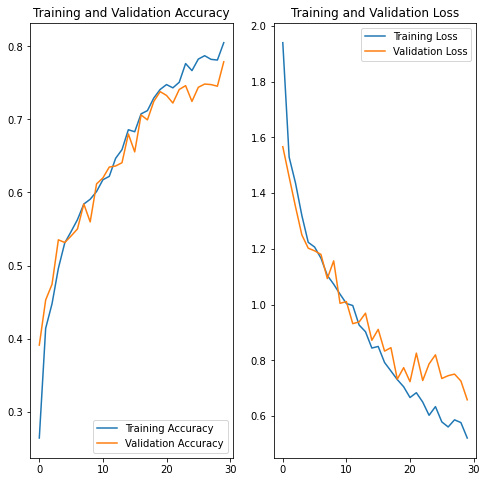

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



## Findings:
We can infer that the Model is fit with a good enough accuracy for both Train and Validation Data of max accuracy around 85%
Rectifying the Class Imbalance and performing Data augumentation on the dataset has resulted in a model with higher accuracy and overcoming overfitting
This is a good model to be used to predict Skin Cancer using CNN